<a href="https://colab.research.google.com/github/Rodisolomon/23_spring_course/blob/main/project4_src_tan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 4: Probabilistic Modeling

## Objectives

This project focuses on probabilistic models and how to fit them.

By the end of this project, you will have implemented the underlying models and fitting procedures:
- Naive Bayes for text classification
- Mixture of Bernoullis (fit via Expectation-Maximization) for generative image modeling

## Deliverable
* Project report/writeup: A `project4_report_lastname.pdf` file with corresponding plots and results for the project. Follow the `Project 4 - Report (Individual Submission)` link on Gradescope to upload this file. Also, please put your name on the report so that the grader can find your code easier on the Gradescope.

    The project report should include a brief justification of your solution at a high-level, e.g., using any relevant explanations, equations, or pictures that help to explain your solution. You should also describe what your code does, e.g. using a couple of sentences per function to describe your code structure. The objective is to make the report self-contained for grading.

    * To be more specific, in addition to textual descriptions and explanations for each sections, you should include images/screenshots/code blocks of:
        1. Any code snippets you implemented
        2. Plots affected by your implementation, e.g., scatter plots with decision boundaries or loss curves.
        3. Output results of the questions, e.g., the best lambda from cross validation.
        4. Please do NOT include debugging messages.

* Source code: A `project4_src_lastname1[_lastname2].ipynb` (or `.zip`) file with a working copy of your solutions compiled in a Jupyter notebook. Follow the `Project 4 - Source Code (Group Submission)` link to upload this file.
    * You are asked to complete code snippets in the following two formats:
        1. Between comments of `Your code starts here` and `End of Your Code`.
        2. Inline comments with `Your code here`.


## Logistics

* You can work in groups of 1-2 students for each course project, and it's your responsibility to find a group (e.g. use Ed Discussion).
* Every member of a group must complete and submit the project report/writeup individually. While the source code can be the same for all group members, the project report needs to be written independently by each person and, thus, should differ among team member and students more generally.
* One one group member need to submit the source code. If you submit as a group, make sure to include your teammate in the group submission. Instructions for team submission can be found [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).
* Grades will be provided based on the individual project report. The source code submission will not be graded, but the teaching staff may check the source files if they see the need for reproducing your results when going through your project report.
* Failure to submit the source code will lead to a deduction of points from your total.


## Task 4A: Naïve Bayes (30pt)

In this assignment, you will be implementing the Naïve Bayes classifier to perform text classification. The Naïve Bayes classifier is a probabilistic machine learning model that is based on Bayes' theorem. It is particularly useful for classification tasks involving high-dimensional data such as text classification.

### Background

#### Bayes' Theorem

Bayes' theorem describes the probability of an event, based on prior knowledge of conditions that might be related to the event. For a class variable $Y$ and a dependent feature vector $X_1$ through $X_n$, Bayes' theorem is stated as:

$$P(Y|X) = \frac{P(X|Y)P(Y)}{P(X)}$$

In the context of text classification, $Y$ represents a particular class (e.g., spam or not spam), and $X$ represents a text document. The theorem is applied to calculate the probability of a document belonging to a class, given the observed words in the document.

#### Naïve Bayes

The Naïve Bayes classifier simplifies the calculation by assuming that the features (words in the case of text classification) are conditionally independent given the class. This assumption allows us to factorize the joint probability $P(X|Y)$ into a product of *individual* probabilities:

$$P(X|Y) = \prod_{i=1}^{n} P(X_i|Y)$$

where $P(X_i|Y)$ is the probability of word $i$ occurring in a document of class $Y$.

This assumption dramatically simplifies the fitting procedure. Naturally, this model is "naive" because the features are typically not so simple as to be independent of each other, even conditioned on the class label.

#### Using the class-conditional density for classification

Suppose we have some class $c$ and a feature vector $x \in \mathbb{R}^d$. We directly model the density of data as
$$ P_{\theta}(x | y=c) = \prod_{i=1}^d P_{\theta_{ic}}(x_i|y=c) $$
where the $\theta_{ic}$ parameters describe the density of the $i$-th feature in class $c$. For example, if the features are binary, we might use Bernoulli distributions for each feature in each class.

In our case, we will be using the Gaussian distribution to model the data density $P(X|Y)$.
As such, our probabilities $P_{\theta_{ic}}(x_i | y=c)$ will come from the Gaussian density.

Once the parameters have been estimated on some training set, we can classify new data by computing the posterior over the class labels (our model's output of probabilities for each class given some input test data point $x$) using Bayes' theorem:

$$ P_{\theta}(y=c | x) = \frac{ P_{\theta}(y=c) \prod_{i=1}^d P_{\theta}(x_i | y=c) }{ \sum_{c'} P_{\theta}(y=c) \prod_{i=1}^d P_{\theta}(x_i | y=c') } $$

For further reading on Naive Bayes, see Section 9.3 in Murphy's Probabilistic Machine Learning (2022).

### Load dataset


In [ ]:
# Import necessary libraries
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def create_dataset():
    # Generate a dataset for classification
    X, y = make_classification(n_samples=1250, n_features=2, n_redundant=0,
                               n_informative=2, random_state=1,
                               n_clusters_per_class=1)

    # Add noise to make the dataset linearly inseparable
    rng = np.random.RandomState(2)
    X += 3 * rng.uniform(size=X.shape)

    # Scale the features
    X = StandardScaler().fit_transform(X)

    return X, y

# Generate the dataset
X, y = create_dataset()

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Starter code

This code has been provided for you; there is no need to modify it.

In [ ]:
import numpy as np

def gaussian_pdf(x, mean, var):
    """Calculate the Gaussian probability density function."""
    eps = 1e-4  # to prevent division by zero
    coeff = 1.0 / np.sqrt(2.0 * np.pi * var + eps)
    exponent = np.exp(-(np.power(x - mean, 2) / (2 * var + eps)))
    return coeff * exponent

def evaluate_accuracy(y_true, y_pred):
    """
    Calculates the accuracy of predictions.

    Parameters:
    - y_true: Array of true labels
    - y_pred: Array of predicted labels

    Returns:
    - Accuracy: The proportion of correctly predicted labels
    """
    correct_predictions = np.sum(y_true == y_pred)
    total_predictions = len(y_true)
    accuracy = correct_predictions / total_predictions
    return accuracy

### Task 4A-I: Calculate Prior Probabilities

Note that in the $P_{\theta}(y=c|x)$ expression we have from earlier, we have the prior class probabilities $P_{\theta}(y=c)$. You can think of this as the empirical probability of seeing class $c$ in the training data. We can calculate these probabilities by counting the occurrences of each class in the training data and dividing by the total number of samples.

Implement the function `calculate_class_priors(y_train)` to calculate and return the prior probabilities \(P(Y)\) of each class in the training dataset.

In [ ]:
# Function to calculate the prior probabilities of each class
def calculate_class_priors(y_train):
    """
    Calculates the prior probabilities P(Y) for each class in the training set.

    For example, if we have a vector y_train = [0, 1, 0, 0, 1, 0]
    composed of two classes 0 and 1, the prior probabilities of each class
    that you would return are:
    {
        0: 0.666,
        1: 0.333,
    }

    Parameters:
    - y_train: Array of training labels

    Returns:
    - Dictionary of prior probabilities for each class
    """
    priors = {}
    for y in y_train:
        if y not in priors:
            priors[y] = 1
        else:
            priors[y] += 1
    for y, p in priors.items():
        priors[y] /= len(y_train)
    return priors

### Task 4A-II: Calculate class-conditional density parameters

Implement the function `calculate_gaussian_density_params(features, labels)` to calculate the parameters of the class-conditional data density \(P(X|Y)\) of observing each feature given each class. Since we're using Gaussians to model the distribution of each feature, you simply need to compute the mean and variance of each feature, conditional on a class.

In [ ]:
# Function to calculate the parameters for the class-conditional Gaussian
# density of each feature
def calculate_gaussian_density_params(features, labels):
    """
    Calculates the likelihood P(X|Y) for each feature given a class.

    For example, if we had one feature X_1 and a target Y \in {0, 1},
    we would return:
    {
        0: [(mean(X_1 | Y=0), var(X_1 | Y=0))],
        1: [(mean(X_1 | Y=1), var(X_1 | Y=1))],
    }

    Parameters:
    - features: Array of features in the training set
    - labels: Array of labels corresponding to the features

    Returns:
    - Dictionary of Gaussian density parameters for each feature given each class
    """
    likelihood = {}
    classes = np.unique(labels)
    for c in classes:
        class_features = features[labels == c]
        class_likelihood = []
        for feature_index in range(class_features.shape[1]):  # Iterate over each feature
            feature_mean = np.mean(class_features[:, feature_index])
            feature_var = np.var(class_features[:, feature_index])
            class_likelihood.append((feature_mean, feature_var))
        likelihood[c] = class_likelihood
    return likelihood

### Task 4A-III: Implement the Classifier

Implement the `naive_bayes_classifier(X_train, y_train, X_test)` function. This function should use the priors and likelihoods calculated in the previous tasks to classify each sample in the test set. Apply Bayes' theorem to compute the posterior probability for each class given the sample and predict the class with the highest posterior probability.

In [ ]:
# Naive Bayes classifier function
def naive_bayes_classifier(X_train, y_train, X_test):
    """
    Classifies each sample in the test set based on the Naive Bayes algorithm.

    Steps:
    - Compute class prior probabilities using the training set labels.
    - Compute class-conditional density parameters from training data.
    - For each sample x in the test set:
        - Use the density params (mu_i, var_i) learned from training data to compute
          the log-likelihood of observing feature x_i.
        - Apply Bayes theorem to compute posterior class probabilities P(y|x)
          from the feature log-likelihood and prior log-likelihood.
          You will use log-likelihood here to avoid underflow.

    Parameters:
    - X_train: Training set features
    - y_train: Training set labels
    - X_test: Test set features

    Returns:
    - Predicted classes for the test set
    """
    predictions = []

    ### P(x|y)P(y)/P(x)
    p_y = calculate_class_priors(y_train)
    p_x_y = calculate_gaussian_density_params(X_train, y_train)
    for x in X_test:
        posteriors = {}
        # posterior probability for each class
        for y, p_y_class in p_y.items():
            p_x_given_y = 1.0
            for feature_index, (mean, var) in enumerate(p_x_y[y]):
                p_x_given_y *= gaussian_pdf(x[feature_index], mean, var)
            posterior = p_x_given_y * p_y_class
            posteriors[y] = posterior
        # Predict
        predicted_class = max(posteriors, key=posteriors.get)
        predictions.append(predicted_class)
    ### End of your code
    return predictions

### Run the classifier

In [ ]:
predictions = naive_bayes_classifier(X_train, y_train, X_test)

You should see a test accuracy > 75%.

In [ ]:
accuracy = evaluate_accuracy(predictions, y_test)
print(f"The test accuracy is {accuracy * 100}%.")

The test accuracy is 78.0%.


## Task 4B: Image Completion with Mixture of Bernoullis and EM (70pt + 20 bonus pt )

### Background

#### Mixture of Bernoullis
Each image we'll deal with is 28-by-28, and each pixel takes values in $\{0, 1\}$. For simplicity, we ignore the spatial structure of the images, and flatten the image into a 784-dimensional binary vectors.

Each mixture of Bernoullis component consists of a collection of independent Bernoulli random variables. By denoting the image as $\mathbf{x} \in \mathbb{R}^{784}$, and the latent variable $z$. Then the conditional probability of an image $\mathbf{x} = \mathbf{x}^{(i)}$ given the label ${z}=k$ is
\begin{align}
    p(\mathbf{x}^{(i)}|{z}=k)&= \prod_{j=1}^{784} p(\mathbf{x}_{j}^{(i)}|z=k) \\
    & =  \prod_{j=1}^{784} \mathbf{\theta}_{k, j}^{\mathbf{x}_{j}^{(i)}} (1-\mathbf{\theta}_{k, j})^{1-\mathbf{x}_{j}^{(i)}}
\end{align}


You should try to understand where this formula comes from. You'll find it useful when you do the derivations. This can be written out as the following generative process:

1. Sample z from a multinomial distribution with parameter vector $\mathbf{\pi}$, where $\mathbf{\pi}$ is a $K$-dimensional vector in our case.

2. For j = 1, ..., 784: Sample $\mathbf{x}_j$ from a Bernoulli distribution with parameter $\mathbf{\theta}_{k,j}$, where $k$ is the value of $z$ from the first step.

More formally, this can be written mathematically as:
$$z \sim \text{Multinomial}(\mathbf{\pi})$$
$$x_j|z=k \sim \text{Bernoulli}(\theta_{k,j})$$



#### Summary of notations

The inputs (i.e., the training data) are represented by $\mathbf{X}$, which is a $N$-by-$D$ binary matrix. In the E-step,we compute $\mathbf{R}$, the matrix of membership weights, which is a $N$-by-$K$ matrix with $K$ being the number of components. Each row of $\mathbf{R}$ gives the membership weights for one training example.

The **trainable parameters** of the model, written out as vectors and matrices, are:

$$\mathbf{\pi} = \begin{bmatrix}\pi_1 \\ \pi_2 \\\cdots \\ \pi_K\end{bmatrix}$$
$$\mathbf{\Theta} = \begin{bmatrix} \theta_{1,1} & \theta_{1,2} & \ldots & \theta_{1, N} \\ \theta_{2,1} & \theta_{2,2} & \ldots & \theta_{2, N} \\ \cdots & & \ddots & \cdots \\ \theta_{K,1} & \theta_{K,2} & \ldots & \theta_{K, N}\end{bmatrix}$$

Since we are using the MNIST dataset, we have $N=60000$, and $D=784$.

### Starter code

This code has been provided for you; there is no need to modify it.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/uchicago_winter_24/ML/project_4

/content/drive/My Drive/uchicago_winter_24/ML/project_4


In [3]:
import numpy as np
import pylab
import time

# import checking
import util

try:
    from scipy.special import gammaln
except:
    pass

IMAGE_DIM = 28

TRAIN_IMAGES_FILE = 'train-images-idx3-ubyte'
TRAIN_LABELS_FILE = 'train-labels-idx1-ubyte'
TEST_IMAGES_FILE = 't10k-images-idx3-ubyte'
TEST_LABELS_FILE = 't10k-labels-idx1-ubyte'


def beta_log_pdf(theta, a, b):
    """Log PDF of the beta distribution. We don't need this function, but we
    include it in case you're interested. You need SciPy in order to use it."""
    norm_const = gammaln(a + b) - gammaln(a) - gammaln(b)
    return norm_const + (a - 1.) * np.log(theta) + (b - 1.) * np.log(1. - theta)

def beta_log_pdf_unnorm(theta, a, b):
    """Unnormalized log PDF of the beta distribution."""
    return (a - 1.) * np.log(theta) + (b - 1.) * np.log(1. - theta)

def dirichlet_log_pdf(pi, a):
    """Log PDF of the Dirichlet distribution. We don't need this function, but we
    include it in case you're interested. You need SciPy in order to use it."""
    norm_const = gammaln(a.sum()) - gammaln(a).sum()
    return norm_const + np.sum((a - 1.) * np.log(pi))

def dirichlet_log_pdf_unnorm(pi, a):
    """Unnormalized log PDF of the Dirichlet distribution."""
    return np.sum((a - 1.) * np.log(pi))


class Params(object):
    """A class which represents the trainable parameters of the mixture model.
        - pi: the mixing proportions, represented as a K-dimensional array. It must be a
            probability distribution, i.e. the entries must be nonnegative and sum to 1.
        - theta: The Bernoulli parameters for each pixel in each mixture component. This is
            a K x D matrix, where rows correspond to mixture components and columns correspond
            to pixels. """

    def __init__(self, pi, theta):
        self.pi = pi
        self.theta = theta

    @classmethod
    def random_initialization(cls, num_components, num_pixels):
        init_pi = np.ones(num_components) / num_components
        init_theta = np.random.uniform(0.49, 0.51, size=(num_components, num_pixels))
        return Params(init_pi, init_theta)

class Prior(object):
    """A class representing the priors over parameters in the mixture model.
        - a_mix: A scalar valued parameter for the Dirichlet prior over mixing proportions.
        - a_pixels and b_pixels: The scalar-valued parameters for the beta prior over the entries of
            theta. I.e., the entries of theta are assumed to be drawn i.i.d. from the distribution
            Beta(a_pixels, b_pixels). """

    def __init__(self, a_mix, a_pixels, b_pixels):
        self.a_mix = a_mix
        self.a_pixels = a_pixels
        self.b_pixels = b_pixels

    @classmethod
    def default_prior(cls):
        """Return a Prior instance which has reasonable values."""
        return cls(2., 2., 2.)

    @classmethod
    def uniform_prior(cls):
        """Return a set of prior parameters which corresponds to a uniform distribution. Then
        MAP estimation is equivalent to maximum likelihood."""
        return cls(1., 1., 1.)


def multinomial_entropy(p):
    """Compute the entropy of a Bernoulli random variable, in nats rather than bits."""
    p = np.clip(p, 1e-20, np.infty)      # avoid taking the log of 0
    return -np.sum(p * np.log(p))


def variational_objective(model, X, R, pi, theta):
    """Compute the variational lower bound on the log-likelihood that each step of E-M
    is maximizing. This is described in the paper

        Neal and Hinton, 1998. A view of the E-M algorithm that justifies incremental, sparse, and other variants.

    We can test the update rules by verifying that each step maximizes this bound.
    """

    model = Model(model.prior, Params(pi, theta))
    expected_log_prob = model.expected_joint_log_probability(X, R)
    entropy_term = np.sum(multinomial_entropy(R))
    return expected_log_prob + entropy_term

def perturb_pi(pi, eps=1e-6):
    pi = np.random.normal(pi, eps)
    pi = np.clip(pi, 1e-10, np.infty)
    pi /= pi.sum()
    return pi

def perturb_theta(theta, eps=1e-6):
    theta = np.random.normal(theta, eps)
    theta = np.clip(theta, 1e-10, 1. - 1e-10)
    return theta

def perturb_R(R, eps=1e-6):
    R = np.random.normal(R, eps)
    R = np.clip(R, 1e-10, np.infty)
    R /= R.sum(1).reshape((-1, 1))
    return R

def train_from_labels(prior=None, show=True):
    """Fit the mixture model using the labeled MNIST data. There are 10 mixture components,
    one corresponding to each of the digit classes."""

    X = util.read_mnist_images(TRAIN_IMAGES_FILE)
    y = util.read_mnist_labels(TRAIN_LABELS_FILE)
    X_test = util.read_mnist_images(TEST_IMAGES_FILE)
    num_data, num_pixels = X.shape

    if prior is None:
        prior = Prior.default_prior()
    model = Model.random_initialization(prior, 10, IMAGE_DIM**2)

    R = np.zeros((num_data, 10))
    R[np.arange(num_data), y] = 1.
    model.params.pi = model.update_pi(R)
    model.params.theta = model.update_theta(X, R)

    # mask which includes top half of pixels
    M = np.zeros(X.shape, dtype=int)
    M[:, :M.shape[1]//2] = 1

    if show:
        model.visualize_components()
        try:
            model.visualize_predictions(X[:64, :], M[:64, :])
        except:
            print('Posterior predictive distribution not implemented yet.')

        print('Training log-likelihood:', model.log_likelihood(X) / num_data)
        print('Test log-likelihood:', model.log_likelihood(X_test) / X_test.shape[0])

    return model

### Task 4B-I: Parameter Learning via EM (35pt)

In the first step, we’ll learn the parameters of the model given the responsibilities, using the Maximum A Posteriori (MAP) criterion. This corresponds to the M-step of the E-M (Expectation-Maximization) algorithm.

In lecture, we discussed the E-M algorithm in the context of maximum likelihood (ML) learning. This is discussed in detail in slides of Lecture 18 Gaussian Mixture Model, and **you should read those slides carefully before starting this part**.

The MAP case is only slightly different from ML: the only difference is that we add a prior probability term to the objective function in the M-step.
In particular, recall that in the context of ML, the M-step maximizes the objective function:

$$\sum_{i=1}^N \sum_{k=1}^K r^{(i)}_{k} \left[\log p(z^{(i)}=k) + \log p(x^{(i)}|z^{(i)}=k)\right]$$

where the $r^{(i)}_k$ are the membership weights computed during the E-step. In the MAP formulation, we need to incorporate
information about our prior distribution, i.e. we add the (log) prior probability of the parameters:

$$\sum_{i=1}^N \sum_{k=1}^K r^{(i)}_{k} \left[\log p(z^{(i)}=k) + \log p(x^{(i)}|z^{(i)}=k)\right] + \log p(\mathbf{\pi}) + \log p(\mathbf{\Theta})$$

Our prior for $\mathbf{\Theta}$ is as follows: every entry is drawn independently from a [beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) with parameters a and b. The beta distribution is

$$p(\theta_{k,j})\propto \theta_{k,j}^{a-1}(1-\theta_{k,j})^{b-1}$$

Recall that $\propto$ means “proportional to” i.e., the distribution has a normalizing constant to ensure it integrates to 1 which we’re ignoring because we don’t need it for the M-step.

For the prior over mixing proportions $\mathbf{\pi}$, we’ll use the [Dirichlet distribution](http://en.wikipedia.org/wiki/Dirichlet_distribution), which is the conjugate prior for the multinomial distribution. It is a distribution over the probability simplex, i.e.the set of vectors which define a valid probability distribution. The distribution takes the form:

$$p(\mathbf{\pi})\propto \pi_1^{a_1-1}\pi_2^{a_2-1}\ldots\pi_{K}^{a_K-1}$$

For simplicity, we use a symmetric Dirichlet prior where all the $a_k$ parameters are assumed to be **equal**. Like the beta distribution, the Dirichlet distribution has a normalizing constant which we don’t need when updating the parameters. The beta distribution is actually the special case of the Dirichlet distribution for $K = 2$.

Further reading on the EM algorithm can be found in Section 8.7 of Murphy's Probabilistic Machine Learning (2022).

#### Question: Derive the M-step update rules
Derive the M-step update rules for $\mathbf{\Theta}$ and $\mathbf{\pi}$ by setting the partial derivatives of the following equation to be zero:

$$\sum_{i=1}^N \sum_{k=1}^K r^{(i)}_{k} \left[\log p(z^{(i)}=k) + \log p(x^{(i)}|z^{(i)}=k)\right] + \log p(\mathbf{\pi}) + \log p(\mathbf{\Theta})$$

**Implementation**: Take these formulas and use them to implement the functions `Model.update_pi` and `Model.update_theta` below. Each one should be implemented in terms of NumPy matrix and vector operations. Each one requires only a few lines of code, and should not involve any for loops.

In [4]:
class Model(object):
    """A class implementing the mixture of Bernoullis model. The fields are:
        - prior: an Prior instance
        - params: a Params instance"""

    def __init__(self, prior, params):
        self.prior = prior
        self.params = params

    @classmethod
    def random_initialization(cls, prior, num_components, num_pixels):
        params = Params.random_initialization(num_components, num_pixels)
        return cls(prior, params)

    def expected_joint_log_probability(self, X, R):
        """Compute the expected joint log probability, where the expectation is with respect to
        the responsibilities R. This is the objective function being maximized in the M-step.
        It's useful for verifying the optimality conditions in the M-step."""

        total = 0.

        # Prior over mixing proportions
        total += dirichlet_log_pdf_unnorm(self.params.pi, self.prior.a_mix)

        # Prior over pixel probabilities
        total += np.sum(beta_log_pdf_unnorm(self.params.theta, self.prior.a_pixels, self.prior.b_pixels))

        # Probability of assignments
        total += np.sum(R * np.log(self.params.pi))

        # Matrix of log probabilities of observations conditioned on z
        # The (i, k) entry is p(x^(i) | z^(i) = k)
        log_p_x_given_z = np.dot(X, np.log(self.params.theta).T) + \
                          np.dot(1. - X, np.log(1. - self.params.theta).T)

        # Observation probabilities
        total += np.sum(R * log_p_x_given_z)

        return total

    def log_likelihood(self, X):
        """Compute the log-likelihood of the observed data, i.e. the log probability with the
        latent variables marginalized out."""

        # Matrix of log probabilities of observations conditioned on z
        # The (i, k) entry is p(x^(i) | z^(i) = k)
        log_p_x_given_z = np.dot(X, np.log(self.params.theta).T) + \
                          np.dot(1. - X, np.log(1. - self.params.theta).T)
        log_p_z_x = log_p_x_given_z + np.log(self.params.pi)

        # This is a numerically stable way to compute np.log(np.sum(np.exp(log_p_z_x), axis=1))
        log_p_x = np.logaddexp.reduce(log_p_z_x, axis=1)

        return log_p_x.sum()

    def update_pi(self, R):
        """Compute the update for the mixing proportions in the M-step of the E-M algorithm.
        You should derive the optimal value of pi (the one which maximizes the expected log
        probability) by setting the partial derivatives of the Lagrangian to zero. You should
        implement this in terms of NumPy matrix and vector operations, rather than a for loop."""
        epsilon = 1e-9  # avoid divided by zero
        self.params.pi = np.clip(np.sum(R, axis=0) / R.shape[0], epsilon, 1 - epsilon)
        return self.params.pi

    def update_theta(self, X, R):
        """Compute the update for the Bernoulli parameters in the M-step of the E-M algorithm.
        You should derive the optimal value of theta (the one which maximizes the expected log
        probability) by setting the partial derivatives to zero. You should implement this in
        terms of NumPy matrix and vector operations, rather than a for loop."""

        ######################## Your code here #########################
        epsilon = 1e-9  # avoid division by zero
        numerator = np.dot(R.T, X)
        denominator = np.sum(R, axis=0)[:, np.newaxis]
        self.params.theta = np.clip(numerator / denominator, epsilon, 1 - epsilon)
        return self.params.theta

    def compute_posterior(self, X, M=None):
        """Compute the posterior probabilities of the cluster assignments given the observations.
        This is used to compute the E-step of the E-M algorithm. It's also used in computing the
        posterior predictive distribution when making inferences about the hidden part of the image.
        It takes an optional parameter M, which is a binary matrix the same size as X, and determines
        which pixels are observed. (1 means observed, and 0 means unobserved.)
        Your job is to compute the variable log_p_z_x, which is a matrix whose (i, k) entry is the
        log of the joint proability, i.e.
             log p(z^(i) = k, x^(i)) = log p(z^(i) = k) + log p(x^(i) | z^(i) = k)
        Hint: the solution is a small modification of the computation of log_p_z_x in
        Model.log_likelihood.
        """

        if M is None:
            M = np.ones(X.shape, dtype=int)

        ######################## Your code here #########################
        epsilon = 1e-9
        theta_adjusted = np.clip(self.params.theta, epsilon, 1 - epsilon)

        log_p_x_given_z = np.dot(X * M, np.log(theta_adjusted).T) + \
                        np.dot((1 - X) * M, np.log(1 - theta_adjusted).T)

        log_p_z_x = log_p_x_given_z + np.log(self.params.pi)

        # subtract the max to avoid numerical instability
        log_p_z_x_shifted = log_p_z_x - log_p_z_x.max(1).reshape((-1, 1))

        # convert to probabilities and renormalize
        R = np.exp(log_p_z_x_shifted)
        R /= R.sum(1).reshape((-1, 1))
        return R



    def posterior_predictive_means(self, X, M):
        """Compute the matrix of posterior predictive means for unobserved pixels given the observed
        pixels. The matrix M is a binary matrix the same size as X which determines which pixels
        are observed. (1 means observed, and 0 means unobserved.) You should return a real-valued
        matrix the same size as X. For all the entries corresponding to unobserved pixels, the value
        should determine the posterior probability that the pixel is on, conditioned on the observed
        pixels. It does not matter what values you assign for observed pixels, since those values
        aren't used for anything. """
        return np.dot(self.compute_posterior(X, M), self.params.theta)

    def visualize_components(self, title=None):
        """Visualize the learned components. Each of the images shows the Bernoulli parameters
        (probability of the pixel being 1) for one of the mixture components."""

        pylab.figure('Mixture components')
        pylab.matshow(util.arrange(self.params.theta.reshape((-1, IMAGE_DIM, IMAGE_DIM))),
                      fignum=False, cmap='gray')
        if title is None:
            title = 'Mixture components'
        pylab.title(title)
        pylab.draw()

    def visualize_predictions(self, X, M, title=None):
        """Visualize the predicted probabilities for each of the missing pixels."""

        P = self.posterior_predictive_means(X, M)
        imgs = np.where(M, X, P)
        obs = np.where(M, X, 0.3)

        pylab.figure('Observations')
        pylab.matshow(util.arrange(obs.reshape((-1, IMAGE_DIM, IMAGE_DIM))),
                      fignum=False, cmap='gray')
        pylab.title('Observations')

        pylab.figure('Model predictions')
        pylab.matshow(util.arrange(imgs.reshape((-1, IMAGE_DIM, IMAGE_DIM))),
                      fignum=False, cmap='gray')
        if title is None:
            title = 'Model predictions'
        pylab.title(title)
        pylab.draw()


**Checking**: Once you have finished the implementation, please run `check_m_step()` for a sanity check. If you pass this sanity check, your implementation is probably correct. (You **DON'T** need to understand how the code works.)

In [5]:
def check_m_step():
    """Check that the M-step updates by making sure they maximize the variational
    objective with respect to the model parameters."""
    np.random.seed(0)

    NUM_IMAGES = 100

    X = util.read_mnist_images(TRAIN_IMAGES_FILE)
    X = X[:NUM_IMAGES, :]
    R = np.random.uniform(size=(NUM_IMAGES, 10))
    R /= R.sum(1).reshape((-1, 1))
    model = Model.random_initialization(Prior.default_prior(), 10, 784)

    theta = model.update_theta(X, R)
    pi = model.update_pi(R)



    opt = variational_objective(model, X, R, pi, theta)

    ok = True
    for i in range(20):
        new_theta = perturb_theta(theta)
        new_obj = variational_objective(model, X, R, pi, new_theta)
        if new_obj > opt:
            ok = False
    if ok:
        print('The theta update seems OK.')
    else:
        print('Something seems to be wrong with the theta update.')

    if not np.allclose(np.sum(pi), 1.):
        print('Uh-oh. pi does not seem to sum to 1.')
    else:
        ok = True
        for i in range(20):
            new_pi = perturb_pi(pi)
            new_obj = variational_objective(model, X, R, new_pi, theta)
            if new_obj > opt:
                ok = False
        if ok:
            print('The pi update seems OK.')
        else:
            print('Something seems to be wrong with the pi update.')

In [ ]:
check_m_step()

The theta update seems OK.
The pi update seems OK.


<ipython-input-13-28988cda6875>:29: RuntimeWarning: divide by zero encountered in log
  return (a - 1.) * np.log(theta) + (b - 1.) * np.log(1. - theta)
<ipython-input-17-6eff376b9dc7>:33: RuntimeWarning: divide by zero encountered in log
  log_p_x_given_z = np.dot(X, np.log(self.params.theta).T) + \


### Task 4B-II: Posterior inference (30pt)
Now we derive the posterior probability distribution $p(z|\mathbf{x}_{\text{obs}})$, where $\mathbf{x}_{\text{obs}}$ denotes the subset of the
pixels which are observed. In the implementation, we will represent partial observations in terms
of variables $m^{(i)}_j$, where $m^{(i)}_j=1$ if the $j$th pixel of the $i$th image is observed, and $0$ otherwise. In the implementation, we organize the $m_j^{(i)}$'s into a matrix $\mathbf{M}$ which is the same shape as $\mathbf{X}$.

#### Question: Computing the posterior

Derive the rule for computing the posterior probability distribution $p(z|\mathbf{x})$. Your final answer should look something like,

$$p(z=k|\mathbf{x})= \ldots$$

where the ellipsis represents something you could actually implement. Note that the image
may be only partially observed.

**Implementation**: Implement the method `Model.compute_posterior` using your solution to the previous question. While your answer to Question 1 was probably given in terms of probabilities, we do the computations in terms of log probabilities for numerical stability. We’ve already filled in part of the implementation, so your job is to compute $\log p(z, \mathbf{x})$ as described in the method’s doc string.

Your implementation should use NumPy matrix and vector operations, rather than a for loop. *Hint: There are two lines in `Model.log_likelihood` which are almost a solution to this question. You can reuse these lines as part of the solution, except you’ll need to modify them to deal with partial observations.*

In [6]:
def check_e_step():
    """Check the E-step updates by making sure they maximize the variational
    objective with respect to the responsibilities. Note that this does not
    fully check your solution to Part 2, since it only applies to fully observed
    images."""

    np.random.seed(0)

    NUM_IMAGES = 100

    X = util.read_mnist_images(TRAIN_IMAGES_FILE)
    X = X[:NUM_IMAGES, :]
    model = train_from_labels(show=False)

    # reduce the number of observations so that the posterior is less peaked
    X = X[:, ::50]
    model.params.theta = model.params.theta[:, ::50]

    R = model.compute_posterior(X)

    opt = variational_objective(model, X, R, model.params.pi, model.params.theta)

    if not np.allclose(R.sum(1), 1.):
        print('Uh-oh. Rows of R do not seem to sum to 1.')
    else:
        ok = True
        for i in range(20):
            new_R = perturb_R(R)
            new_obj = variational_objective(model, X, new_R, model.params.pi, model.params.theta)
            if new_obj > opt:
                ok = False
        if ok:
            print('The E-step seems OK.')
        else:
            print('Something seems to be wrong with the E-step.')

**Checking**: To help you check your solution, we’ve provided the function `check_e_step()`. Note that this check only covers the case where the image is fully observed, so it doesn’t fully verify your solution to this part.

In [ ]:
check_e_step()

The E-step seems OK.


<ipython-input-13-28988cda6875>:29: RuntimeWarning: divide by zero encountered in log
  return (a - 1.) * np.log(theta) + (b - 1.) * np.log(1. - theta)
<ipython-input-28-3b612cf1f2fb>:33: RuntimeWarning: divide by zero encountered in log
  log_p_x_given_z = np.dot(X, np.log(self.params.theta).T) + \


### Task 4B-III: Report the results (5pt)

Run the following code  to generate the results and compile them in the final report.

In [ ]:
def train_with_em(num_components=100, num_steps=50, prior=None, draw_every=1):
    """Fit the mixture model in an unsupervised fashion using E-M."""

    X = util.read_mnist_images(TRAIN_IMAGES_FILE)
    X_test = util.read_mnist_images(TEST_IMAGES_FILE)
    num_data, num_pixels = X.shape

    if prior is None:
        prior = Prior.default_prior()
    model = Model.random_initialization(prior, num_components, num_pixels)

    # mask which includes top half of pixels
    M = np.zeros(X.shape, dtype=int)
    M[:, :M.shape[1]//2] = 1

    loglik_vals = []

    for i in range(num_steps):
        # E-step
        R = model.compute_posterior(X)

        # M-step
        model.params.pi = model.update_pi(R)
        model.params.theta = model.update_theta(X, R)

        loglik = model.log_likelihood(X) / num_data
        loglik_vals.append(loglik)

        if (i+1) % draw_every == 0:
            model.visualize_components()
            model.visualize_predictions(X[:64, :], M[:64, :])

            pylab.figure('Log-likelihood')
            pylab.clf()
            pylab.semilogx(np.arange(1, i+2), loglik_vals)
            pylab.title('Log-likelihood')
            pylab.xlabel('Number of E-M steps')
            pylab.draw()

    print('Final training log-likelihood:', model.log_likelihood(X) / num_data)
    print('Final test log-likelihood:', model.log_likelihood(X_test) / X_test.shape[0])

    return model

Final training log-likelihood: -136.72159484936012
Final test log-likelihood: -137.42492477619905


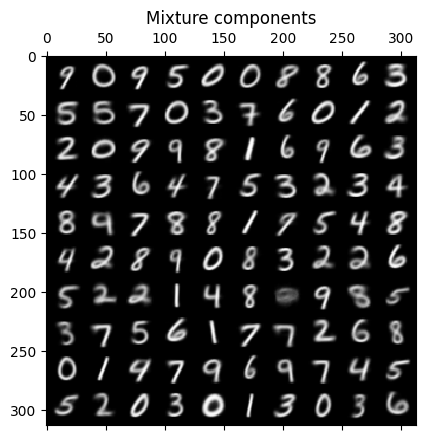

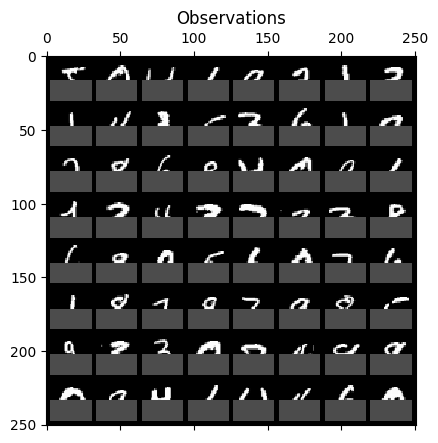

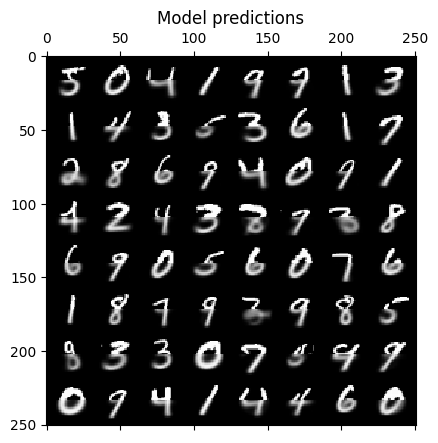

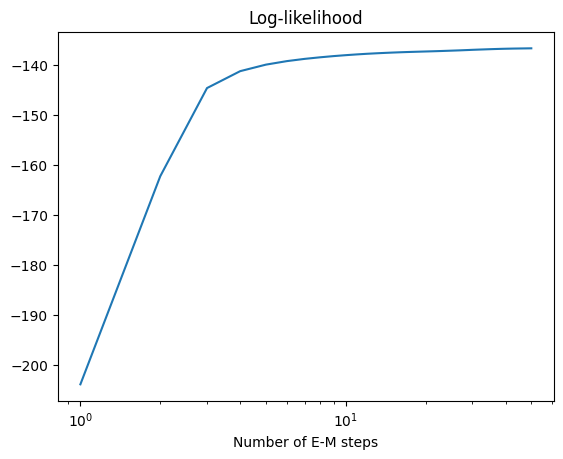

In [ ]:
# This will take several minutes (<10 minutes) to finish.
model = train_with_em(num_components=100, num_steps=50)

### Bonus (20 Pt): Task 4B-IV: Anomaly detection

Please implement an anomaly detection algorithm for the provided dataset, which includes one outlier. Your implementation should be able to detect the outlier based on previous methods and also visualize the results.



In [28]:
X_test = util.read_mnist_images(TEST_IMAGES_FILE)
for i in range(20):
    outlier = np.random.randn(1, 784)
    X_test = np.vstack([X_test, outlier])

Visualizing Normal Images


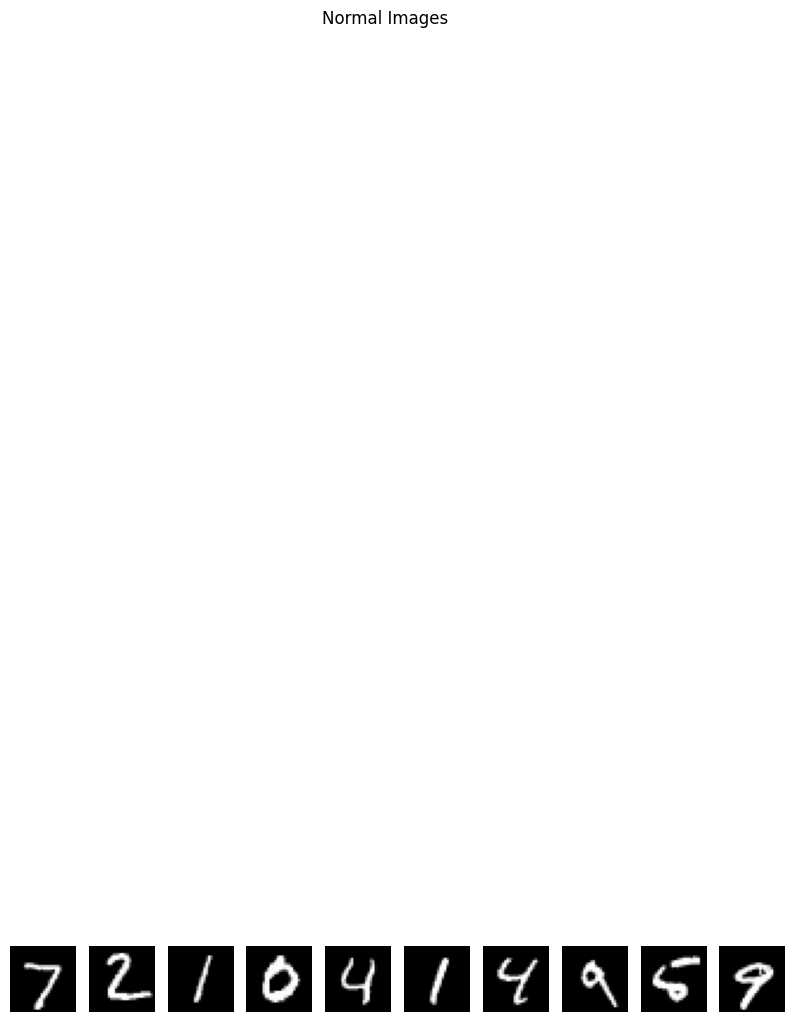

Visualizing Detected Outlier(s)
[ 1801  3727  3841  4086  6161 10014 10015 10018]


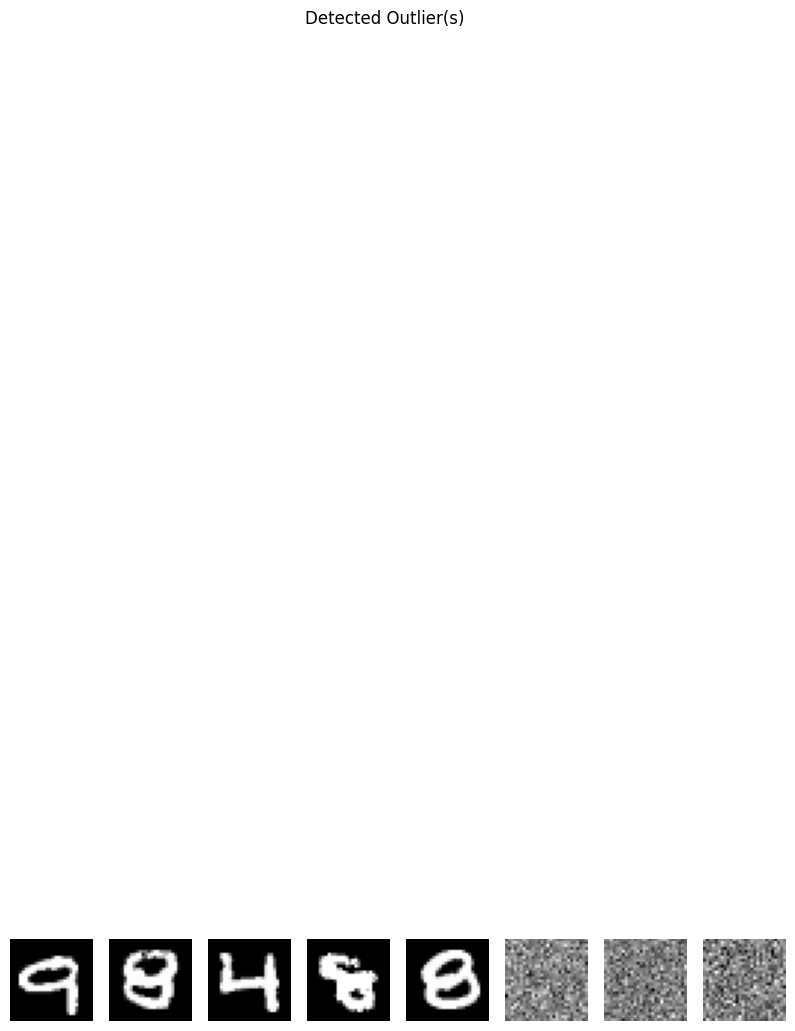

In [34]:
import numpy as np
import matplotlib.pyplot as plt

model = train_from_labels(show=False)
log_likelihoods = np.array([model.log_likelihood(sample.reshape(1, -1)) for sample in X_test])

# Normalize log-likelihoods for comparison
log_likelihoods = log_likelihoods / len(X_test[0])

mean_ll = np.mean(log_likelihoods)
std_ll = np.std(log_likelihoods)
threshold = mean_ll - 3.7 * std_ll  #threshold
outliers = np.where(log_likelihoods < threshold)[0]  # indices of outliers

def visualize_images(images, title='Images', indices=None, n=10):
    """Visualize n images from the provided array, optionally at specific indices."""
    plt.figure(figsize=(10, n*2))
    if indices is not None:
        images_to_show = images[indices]
    else:
        images_to_show = images[:n]
    for i, image in enumerate(images_to_show):
        plt.subplot(1, len(images_to_show), i + 1)
        plt.imshow(image.reshape((28, 28)), cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

print("Visualizing Normal Images")
visualize_images(X_test, 'Normal Images', n=10)
print("Visualizing Detected Outlier(s)")
print(outliers)
visualize_images(X_test, 'Detected Outlier(s)', indices=outliers)
